# exponential_smoothing

- Explore how exponential smoothing using different alpha and window parameters are correlated with returns at time t+1

In [44]:
import os
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import itertools

In [3]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [4]:
print(df.shape)
df.head()

(2490, 793)


ticker        date        open        high         low       close  \
0   AAPL  2024-05-01  169.580002  172.710007  169.110001  169.300003   
1   AAPL  2024-05-02  172.509995  173.419998  170.889999  173.029999   
2   AAPL  2024-05-03  186.649994  187.000000  182.660004  183.380005   
3   AAPL  2024-05-06  182.350006  184.199997  180.419998  181.710007   
4   AAPL  2024-05-07  183.449997  184.899994  181.320007  182.399994   

        volume  return_t+1                                          headlines  \
0   50383100.0    0.022032                                                 []   
1   94214900.0    0.059816                                                 []   
2  163224100.0   -0.009107                                                 []   
3   78569700.0    0.003797                                                 []   
4   77305800.0    0.001864  [From Apple to Wayfair: A Lot of Earnings Resu...   

   finbert_0  ...  momentum_10  volatility_10  sma_10  momentum_20  \
0   0.000000  ...          NaN            NaN     NaN          NaN   
1   0.000000  ...          NaN            NaN     NaN          NaN   
2   0.000000  ...          NaN            NaN     NaN          NaN   
3   0.000000  ...          NaN            NaN     NaN          NaN   
4   0.030524  ...          NaN            NaN     NaN          NaN   

   volatility_20  sma_20  rsi_14  cumulative_return  running_max  drawdown  
0            NaN     NaN     NaN           0.022032     0.022032  0.000000  
1            NaN     NaN     NaN           0.081848     0.081848  0.000000  
2            NaN     NaN     NaN           0.072741     0.081848 -0.009107  
3            NaN     NaN     NaN           0.076539     0.081848 -0.005310  
4            NaN     NaN     NaN           0.078403     0.081848 -0.003445  

[5 rows x 793 columns]

In [5]:
df.tail()

ticker        date        open        high         low       close  \
2485    XOM  2025-04-23  108.809998  109.300003  106.470001  107.370003   
2486    XOM  2025-04-24  107.970001  108.879997  106.959999  108.629997   
2487    XOM  2025-04-25  108.139999  108.760002  107.419998  108.570000   
2488    XOM  2025-04-28  108.750000  109.250000  107.680000  108.629997   
2489    XOM  2025-04-29  107.739998  108.830002  107.519997  108.360001   

          volume  return_t+1  \
2485  14235700.0    0.011735   
2486   9849600.0   -0.000552   
2487  11245800.0    0.000553   
2488  13890900.0   -0.002485   
2489   9483100.0   -0.025194   

                                              headlines  finbert_0  ...  \
2485  [Will Exxon (XOM) Beat Estimates Again in Its ...   0.067738  ...   
2486  [Exxon Mobil (NYSE:XOM) Partners With Calpine ...   0.076386  ...   
2487  [Guyana Q1 oil production sees 3% YoY increase...  -0.027245  ...   
2488  [Oil Slumps as Traders Await Next Moves in Chi...  -0.336978  ...   
2489  [Exxon Mobil Q1 Earnings Boosted by Upstream, ...  -0.062517  ...   

      momentum_10  volatility_10      sma_10  momentum_20  volatility_20  \
2485     0.065496       0.025919  104.749001    -0.079080       0.029937   
2486     0.026749       0.016133  105.032000    -0.081508       0.029946   
2487     0.086461       0.013922  105.896000    -0.079057       0.029957   
2488     0.053229       0.014119  106.445000    -0.077296       0.029783   
2489     0.048070       0.016950  106.942000    -0.088876       0.030117   

        sma_20     rsi_14  cumulative_return  running_max  drawdown  
2485  108.9250  48.233291          -0.037891     0.086817 -0.124708  
2486  108.4430  50.593522          -0.038443     0.086817 -0.125260  
2487  107.9770  50.475508          -0.037890     0.086817 -0.124707  
2488  107.5220  50.599603          -0.040376     0.086817 -0.127193  
2489  106.9935  49.992519          -0.065570     0.086817 -0.152387  

[5 rows x 793 columns]

In [112]:
def apply_exponential_smoothing(df, smooth_col, alpha=0.1):
    """
    Applies exponential smoothing to a given column in the DataFrame, separately by ticker.
    
    Args:
        df (pd.DataFrame): DataFrame containing the stock data
        smooth_col (str): Column name to apply smoothing (e.g., 'open', 'close')
        alpha (float): Smoothing factor (0 < alpha <= 1)

    Returns:
        pd.Series: Exponentially smoothed values by ticker
    """
    smoothed_values = []

    # Group by ticker to apply smoothing separately
    for ticker, group in df.groupby('ticker'):
        smoothed_group = []
        
        # Initialize the smoothed value for the first entry in the group
        smoothed_value = group[smooth_col].iloc[0]
        smoothed_group.append(smoothed_value)
        
        # Apply exponential smoothing to the group
        for i in range(1, len(group)):
            value = group[smooth_col].iloc[i]
            smoothed_value = alpha * value + (1 - alpha) * smoothed_value
            smoothed_group.append(smoothed_value)
        
        # Append the smoothed values for this group to the final list
        smoothed_values.extend(smoothed_group)

    return pd.Series(smoothed_values, index=df.index)



In [115]:
df_subset = df[["date", "ticker", "open", "close", "return_t+1"]].copy()
df_subset["return"] = df_subset["return_t+1"].shift(1)

In [116]:
# Test params
smooth_cols = ["open", "close", "return_t+1"]
alphas = [0.25, 0.75, 0.90]

# All params combos
param_combinations = itertools.product(smooth_cols, alphas)

# Apply exponential smoothing
for (smooth_col, alpha) in param_combinations:
    output_col = f"{smooth_col}_smoothed_alpha:{alpha}"
    df_subset[output_col] = apply_exponential_smoothing(
        df_subset, 
        smooth_col=smooth_col, 
        alpha=alpha, 
    )
    if smooth_col == "return_t+1":
        df_subset[output_col.replace("_t+1", "")] = df_subset[output_col].shift(1)

In [118]:
df_subset.query("ticker == 'HD'")[['return_t+1', 'return', 'return_smoothed_alpha:0.25', 'return_smoothed_alpha:0.75', 'return_smoothed_alpha:0.9']]

return_t+1    return  return_smoothed_alpha:0.25  \
498    0.010724 -0.015849                    0.000844   
499    0.021816  0.010724                    0.010724   
500   -0.001633  0.021816                    0.013497   
501   -0.004674 -0.001633                    0.009714   
502   -0.005460 -0.004674                    0.006117   
..          ...       ...                         ...   
742    0.009034  0.005615                    0.003318   
743   -0.005728  0.009034                    0.004747   
744   -0.001846 -0.005728                    0.002129   
745    0.005828 -0.001846                    0.001135   
746    0.004150  0.005828                    0.002308   

     return_smoothed_alpha:0.75  return_smoothed_alpha:0.9  
498                   -0.012230                  -0.014459  
499                    0.010724                   0.010724  
500                    0.019043                   0.020707  
501                    0.003536                   0.000601  
502                   -0.002622                  -0.004147  
..                          ...                        ...  
742                    0.007439                   0.006821  
743                    0.008636                   0.008813  
744                   -0.002137                  -0.004274  
745                   -0.001919                  -0.002088  
746                    0.003891                   0.005036  

[249 rows x 5 columns]

In [119]:
df_subset.query("ticker == 'HD'")[["return_t+1", 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9']]

return_t+1  return_t+1_smoothed_alpha:0.25  \
498    0.010724                        0.010724   
499    0.021816                        0.013497   
500   -0.001633                        0.009714   
501   -0.004674                        0.006117   
502   -0.005460                        0.003223   
..          ...                             ...   
742    0.009034                        0.004747   
743   -0.005728                        0.002129   
744   -0.001846                        0.001135   
745    0.005828                        0.002308   
746    0.004150                        0.002769   

     return_t+1_smoothed_alpha:0.75  return_t+1_smoothed_alpha:0.9  
498                        0.010724                       0.010724  
499                        0.019043                       0.020707  
500                        0.003536                       0.000601  
501                       -0.002622                      -0.004147  
502                       -0.004750                      -0.005328  
..                              ...                            ...  
742                        0.008636                       0.008813  
743                       -0.002137                      -0.004274  
744                       -0.001919                      -0.002088  
745                        0.003891                       0.005036  
746                        0.004086                       0.004239  

[249 rows x 4 columns]

In [120]:
df_subset.query("ticker == 'HD'")[["open", 'open_smoothed_alpha:0.25', 'open_smoothed_alpha:0.75', 'open_smoothed_alpha:0.9']]

open  open_smoothed_alpha:0.25  open_smoothed_alpha:0.75  \
498  333.010010                333.010010                333.010010   
499  335.500000                333.632507                334.877502   
500  341.279999                335.544380                339.679375   
501  346.000000                338.158285                344.419844   
502  343.600006                339.518715                343.804965   
..          ...                       ...                       ...   
742  361.920013                354.382880                359.353221   
743  356.500000                354.912160                357.213305   
744  357.700012                355.609123                357.578335   
745  357.989990                356.204340                357.887077   
746  355.890015                356.125759                356.389280   

     open_smoothed_alpha:0.9  
498               333.010010  
499               335.251001  
500               340.677099  
501               345.467710  
502               343.786776  
..                       ...  
742               360.869949  
743               356.936995  
744               357.623710  
745               357.953362  
746               356.096349  

[249 rows x 4 columns]

## Evaluate different metrics

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import colors

def get_complementary_color(base_color):
    """
    Given a base color in RGB, return its complementary color.
    """
    # Ensure base_color is an RGB color by ignoring the alpha channel (base_color is in RGBA)
    base_rgb = base_color[:3]  # Extract only the RGB part (ignore the alpha channel)
    
    # Convert base RGB to HSV
    base_hsv = colors.rgb_to_hsv(base_rgb)
    
    # Complementary color is achieved by shifting the hue by 180 degrees (0.5 in normalized space)
    complementary_hsv = (base_hsv[0] + 0.5) % 1.0, base_hsv[1], base_hsv[2]
    
    # Convert back to RGB
    complementary_rgb = colors.hsv_to_rgb(complementary_hsv)
    return complementary_rgb

def plot_with_smoothed_metrics(
    df,
    base_metric: str = "open",  # Base metric to plot, such as 'open', 'close', 'return_t+1'
    smoothed_metrics: List[str] = None,  # List of smoothed metrics to plot
    N=5,  # Show every Nth x-tick label
    rotation=45  # X-axis label rotation
):
    """
    Plot the base metric (e.g., 'open', 'close', 'return_t+1') and its smoothed versions (e.g., 'open_smoothed_alpha:0.1_window:5')
    on the same line plot for each ticker in separate subplots.

    Parameters:
        df (pd.DataFrame): Must include ['ticker', 'date', base_metric, and smoothed columns]
        base_metric (str): Base metric to plot (e.g., 'open', 'close', 'return_t+1')
        smoothed_metrics (List[str]): List of smoothed columns to plot
        N (int): Show every Nth x-tick label
        rotation (int): X-axis label rotation
    """
    tickers = df["ticker"].unique()
    colors_base = get_cmap("tab10", len(tickers))

    # Set up the plot with multiple subplots (one per ticker)
    fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 6 * len(tickers)))

    # If there's only one ticker, axes is not a list, so we make sure to handle it
    if len(tickers) == 1:
        axes = [axes]

    # Loop through each ticker and create a subplot
    for i, ticker in enumerate(tickers):
        ax = axes[i]
        df_t = df[df["ticker"] == ticker]
        base_color = colors_base(i)  # Base color for the base metric

        # Get complementary color for smoothed metrics
        complementary_color = get_complementary_color(base_color)  # Get complementary color

        # Plot the base metric (e.g., 'open', 'close', 'return_t+1') on the current subplot
        ax.plot(df_t["date"], df_t[base_metric], label=f"{ticker} {base_metric}", color=base_color)

        # Plot the smoothed metrics if provided
        linestyles = ["-", "--", "-.", ":"]
        if smoothed_metrics:
            for j, smoothed_col in enumerate(smoothed_metrics):
                if smoothed_col in df_t.columns:
                    ax.plot(
                        df_t["date"], 
                        df_t[smoothed_col], 
                        label=f"{ticker} {smoothed_col}", 
                        color=complementary_color, 
                        linestyle=linestyles[j if j < len(linestyles) else j % 2]
                    )

        # Set subplot details
        ax.legend(title="Ticker")

        # Manually set ticks and labels
        ticks = ax.get_xticks()
        num_ticks = len(ticks)
        labels = [label.get_text() for label in ax.get_xticklabels()]
        
        # Ensure labels match tick locations
        if num_ticks > 0:
            ax.set_xticks(ticks[::N])
            ax.set_xticklabels(labels[::N], rotation=rotation)

        # Dynamically adjust Y-limits based on the data range for each subplot
        y_min, y_max = df_t[base_metric].min(), df_t[base_metric].max()
        if smoothed_metrics:
            for smoothed_col in smoothed_metrics:
                if smoothed_col in df_t.columns:
                    y_min = min(y_min, df_t[smoothed_col].min())
                    y_max = max(y_max, df_t[smoothed_col].max())

        ax.set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # Add some padding

        ax.set_xlabel("Date")
        ax.set_ylabel(base_metric.replace("_", " ").capitalize())
        ax.set_title(f"{ticker} - {base_metric.replace('_', ' ').capitalize()} and Smoothed Metrics")

    plt.tight_layout()
    plt.show()


C:\Users\asacco\AppData\Local\Temp\ipykernel_35608\606514394.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base = get_cmap("tab10", len(tickers))


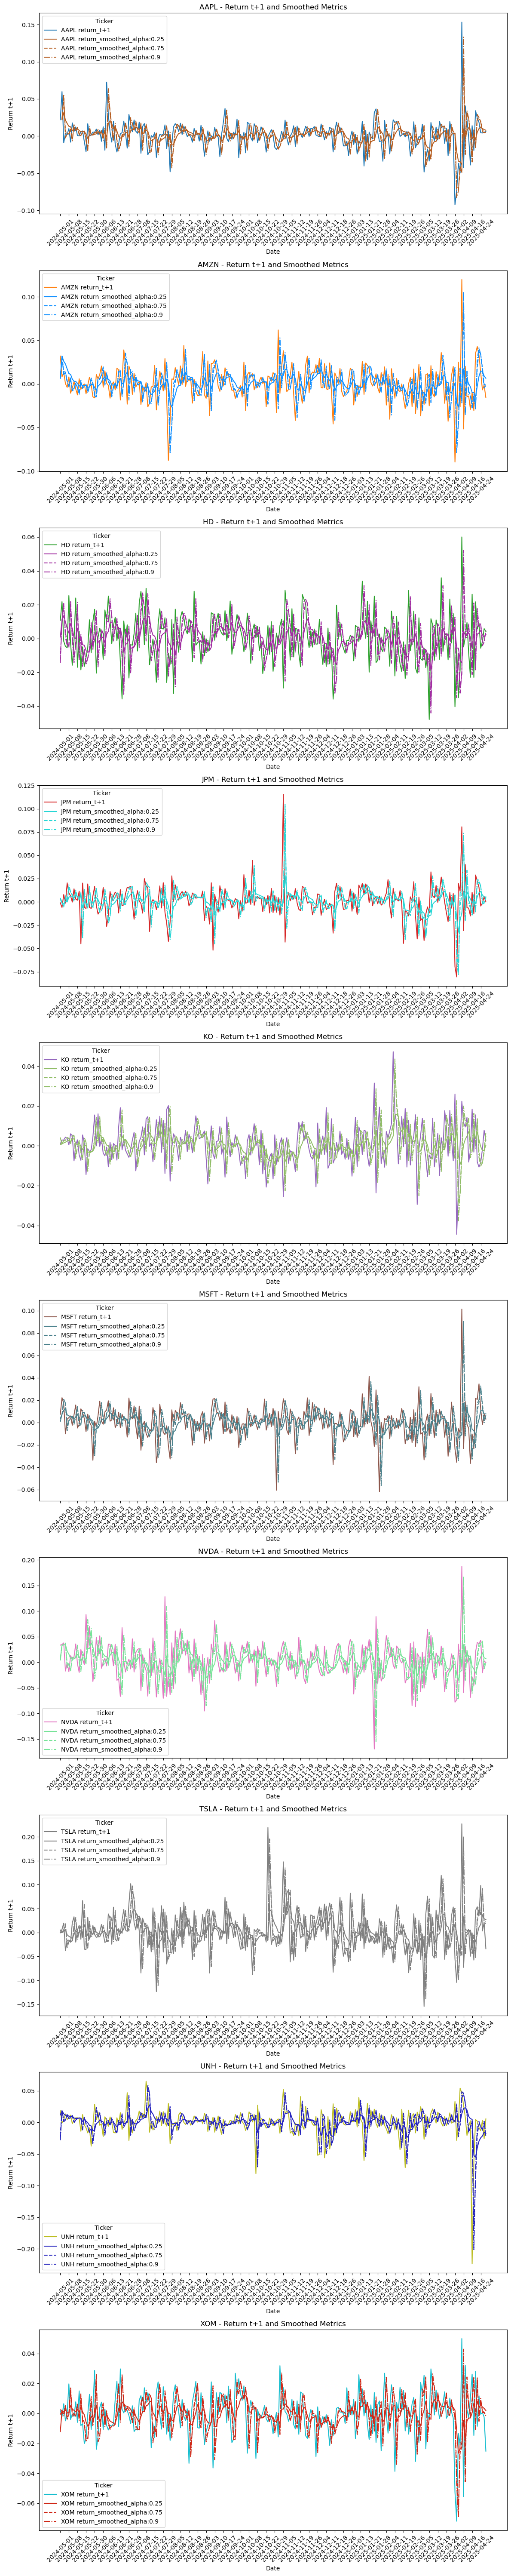

In [123]:
# Define the smoothing metrics you want to plot
smoothed_columns = [
    'return_smoothed_alpha:0.25',
    'return_smoothed_alpha:0.75',
    'return_smoothed_alpha:0.9',
]

# Call the function with the smoothing columns
plot_with_smoothed_metrics(
    df_subset,
    base_metric="return_t+1",
    smoothed_metrics=smoothed_columns,  
    N=5,
    rotation=45
)

<Axes: >

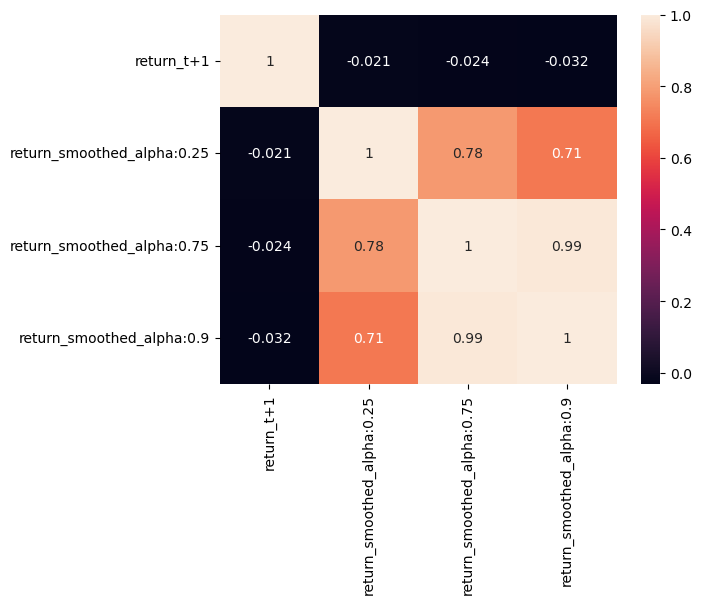

In [126]:
sns.heatmap(df_subset[["return_t+1", "return_smoothed_alpha:0.25", "return_smoothed_alpha:0.75", "return_smoothed_alpha:0.9"]].corr(), annot=True)

C:\Users\asacco\AppData\Local\Temp\ipykernel_35608\606514394.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base = get_cmap("tab10", len(tickers))


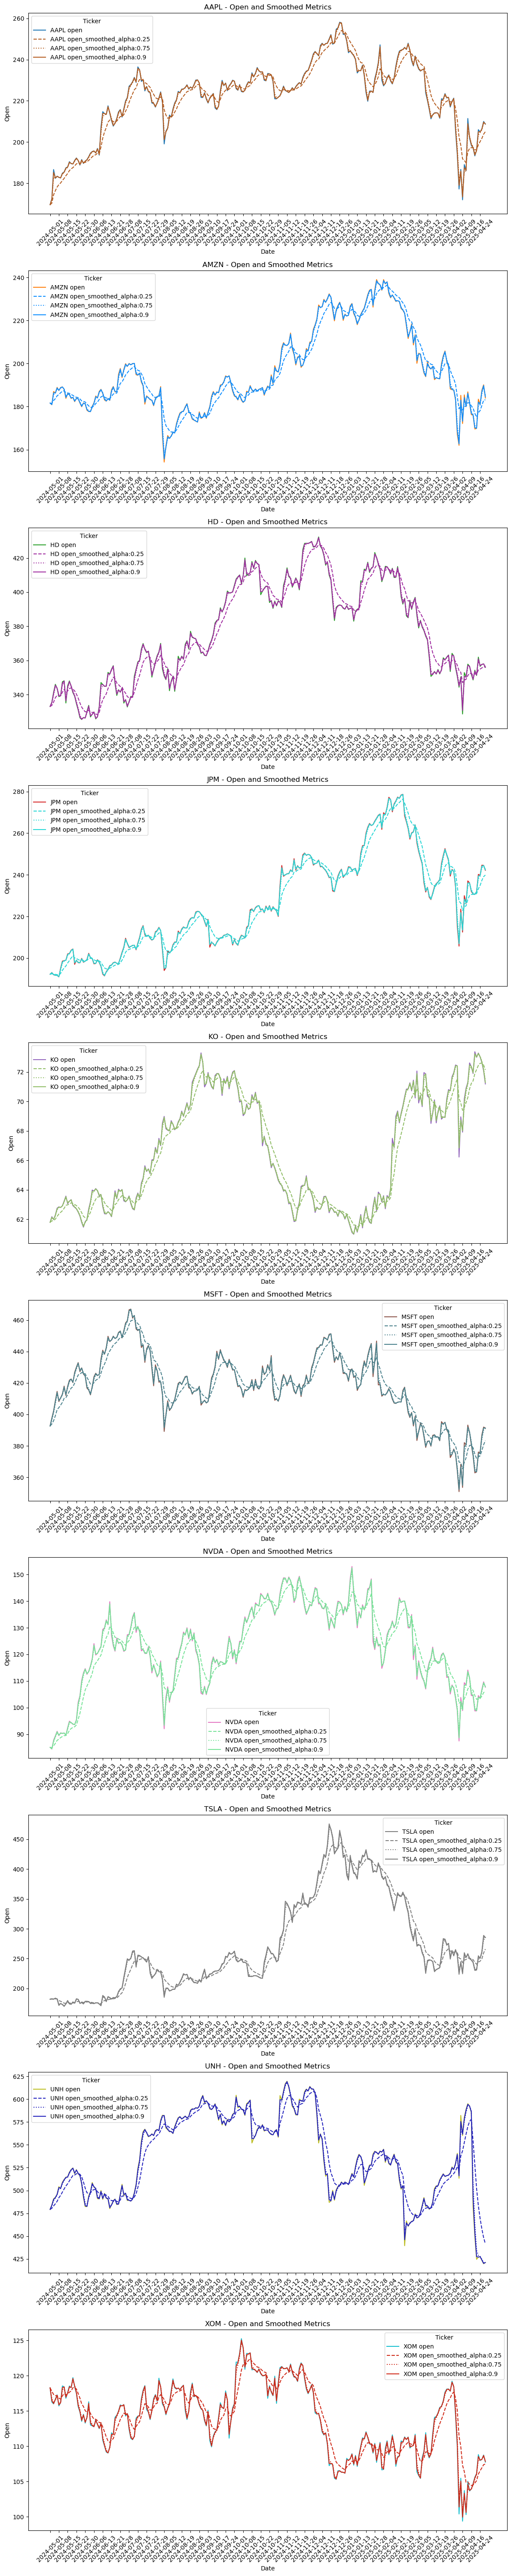

In [127]:
# Define the smoothing metrics you want to plot
smoothed_columns = [
    'open_smoothed_alpha:0.1',
    'open_smoothed_alpha:0.25',
    'open_smoothed_alpha:0.5',
    'open_smoothed_alpha:0.75',
    'open_smoothed_alpha:0.9',
]

# Call the function with the smoothing columns
plot_with_smoothed_metrics(
    df_subset,
    base_metric="open",  
    smoothed_metrics=smoothed_columns,  
    N=5,
    rotation=45
)

C:\Users\asacco\AppData\Local\Temp\ipykernel_35608\606514394.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base = get_cmap("tab10", len(tickers))


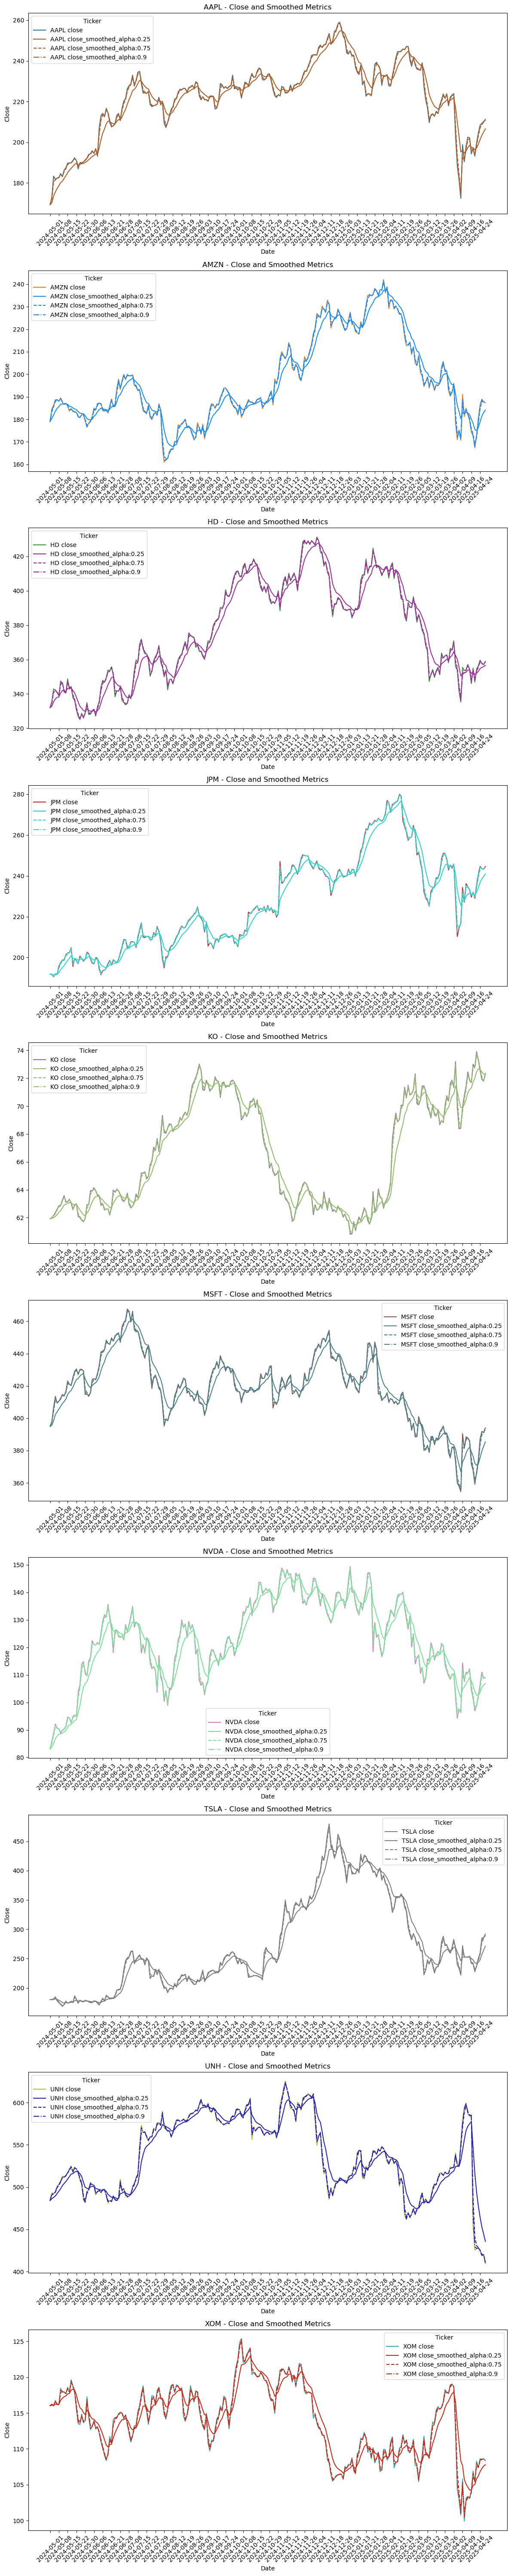

In [129]:
# Define the smoothing metrics you want to plot
smoothed_columns = [
    'close_smoothed_alpha:0.25',
    'close_smoothed_alpha:0.75',
    'close_smoothed_alpha:0.9',
]

# Call the function with the smoothing columns
plot_with_smoothed_metrics(
    df_subset,
    base_metric="close",  
    smoothed_metrics=smoothed_columns,  
    N=5,
    rotation=45
)